# INF4480 Spring of 2021 - Project 4
### By Olav Fønstelien 2021-03-15
<br>

### Notes:
* Besides the lecure notes, I have mainly used the book _Statistical and Adaptive Signal Processing_ by Manolakis et. al. for this project
* Implementation in Python using NumPy, SciPy, matplotlib
* Generating slides from Jupyter Lab, and including most of the code since I myself think it is always interesting to see how things were done, and would also like feedback as well as tips and tricks
* The slides are in reveal.js format. Navigate by going right/left for Assignments 1-2-3 etc., and up/down for sub-assignments 1A-1B-1C etc.
* **NOTE: You may have to zoom out a bit to fit all content of each slide to your screen. I found that 60% worked well for me.**

## Introduction

In this assignment we will look at ....

Let's start by having a look at the data. We begin by setting up the environment...

In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt
from scipy.io import loadmat
from scipy.stats import norm
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['pcolor.shading'] = 'flat'

## Assignment 1 - Constant False Alarm Rate (CFAR) Detector

#### **a)**
The PDF of the signal in noise is given by $f_{\theta}(x) \sim \mathcal{N}(\theta, \sigma^2)$.

#### **b)** 
The false-alarm-rate $P_{FA}$ of a CFAR detector depends on both $\theta, \sigma$. Given the _Neyman-Pearson_ criterion
$$
\Lambda (x) = \frac{f_{\theta}(x)}{f_{n}(x)} 
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\lambda
\stackrel{\text{monotonic}}{\Rightarrow}
\ln \Lambda (x) = \frac{1}{\sigma^2} \bigg( x \theta - \frac{\theta^2}{2} \bigg)
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\ln \lambda
$$
We rearrange and get the threshold $\gamma$ between the hypotheses
$$
x
\begin{subarray}{c}
    H_1 \vphantom{H_1} \\
    > \vphantom{H_1} \\
    < \vphantom{H_1} \\
    H_0 \vphantom{H_1}
\end{subarray}
\frac{\sigma^2 \ln \lambda}{\theta} + \frac{\theta}{2} = \gamma
$$
We know that the false-alarm-rate is given by
$$
P_{FA} = \int_{\Lambda(x)>\lambda} f_n(x) dx = \int_{\gamma}^\infty f_n(x) dx = Q_n(\gamma) = Q_n \bigg( \frac{\sigma^2 \ln \lambda}{\theta} + \frac{\theta}{2} \bigg)
$$

#### **c)**
The false-alarm-rate $P_{FA}$ and the detection-rate $P_D$ are linked by the common detection threshold $\gamma$;
$$
\begin{aligned}
P_{FA} &= Q_n(\gamma) = Q \bigg( \frac{\gamma}{\sigma} \bigg) \\
P_{D} &= Q_{\theta}(\gamma) = Q \bigg( \frac{\gamma - \theta}{\sigma} \bigg)
\end{aligned}
$$
where $Q(\cdot)$ is the normalized survival function. Given $P_{FA} = \alpha$, we can calculate the detection-rate directly by
$$
P_{D} = Q_{\theta}(\sigma Q_n^{-1}(\alpha)) = Q \bigg( Q^{-1}(\alpha) - \frac{\theta}{\sigma} \bigg)
$$
Plugging in $\theta = 5, \sigma = 5$, and $\alpha=0.1$ we get the rather poor detection-rate $ P_{D} = 0.39 $.

In [144]:
# Calculating detection rate
sigma, theta = 5, 5
alpha = .1
P_D = norm.sf(norm.isf(alpha)-theta/sigma)
P_D

0.389143691645361

#### **d)**
Varying the threshold $\gamma$, we can plot the Receiver Operator Characteristic (ROC) Curves for the detector. Using again that
$$
\begin{aligned}
P_{FA} &= Q \bigg( \frac{\gamma}{\sigma} \bigg) \\
P_{D} &= Q \bigg( \frac{\gamma - \theta}{\sigma} \bigg)
\end{aligned}
$$
we see that $P_{FA} = P_D = 1$ for the negative asymptote, $\gamma = - \infty$; and likewise $P_{FA} = P_D = 0$ for the positive asymptote, $\gamma = + \infty$. For a signal in noise, we define the signal-to-noise ratio as
$$
\mathrm{SNR} = \frac{\theta}{\sigma}
$$
We see that $\mathrm{SNR} \ge 0$, and that equality is achieved when either $\theta=0$; or at the limit $\sigma \rightarrow \infty$. These cases represent the straight line between the asymptotes of the threshold on the ROC curve. For all $\mathrm{SNR} > 0$, $P_{FA} > P_D$, and the curve bends upwards towards the upper left corner for increasing $\mathrm{SNR}$.

Below we see the ROC curve for some $\sigma$ at fixed $\theta$.

In [145]:
# Generating ROC curves
theta = 5
sigmas = np.array([1,3,5,10,15]).reshape(-1,1)
gamma = np.linspace(-1000,1000,10000)
P_D = norm.sf((gamma-theta)/sigmas)
P_FA = norm.sf(gamma/sigmas)

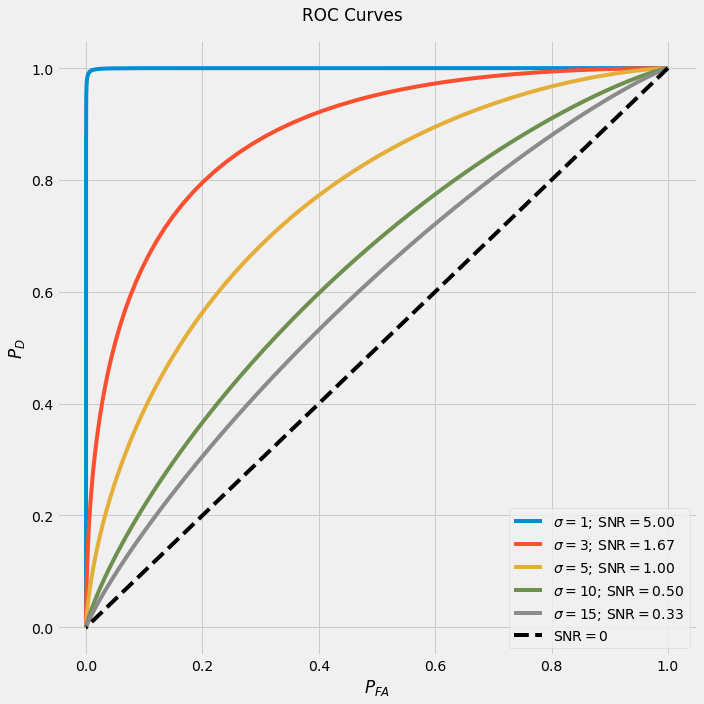

In [146]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'ROC Curves')

ax = axes
ax.plot(P_FA.T, P_D.T)
ax.plot(P_FA[0], P_FA[0], color='0', ls='--')
ax.legend([rf'$\sigma={sigma}$; $\mathrm{{SNR}}={theta/sigma:.2f}$' for sigma in sigmas.squeeze()] + [r'$\mathrm{SNR}=0$'])

ax.set_xlabel(r'$P_{FA}$')
ax.set_ylabel(r'$P_{D}$')


plt.tight_layout()
plt.show()

#### **e)**
In the figure below we see the reason why the performance of the detector in **c)** was poor. The detection rate is given by the area under the "noise+signal" curve, and we see that this covers less than half the area, since
$$
\theta = 5 < \sigma Q^{-1}(\alpha) = 5 \cdot 1.28... \approx 6.4
$$
The variance of PDF of the noise is too high relative to the signal magnitude, i.e. the signal-to-noise ratio is too low; $\mathrm{SNR} = 5/5 = 1$. To help on this situation, we can increase the number of samples, as we will see next.

In [167]:
# Generating PDFs
sigma, theta = 5, 5
x = np.linspace(-25,25,1000)
fn = norm.pdf(x, loc=0, scale=sigma)
fs = norm.pdf(x, loc=theta, scale=sigma)

# Threshold
alpha = .1
gamma = norm.isf(alpha)*sigma

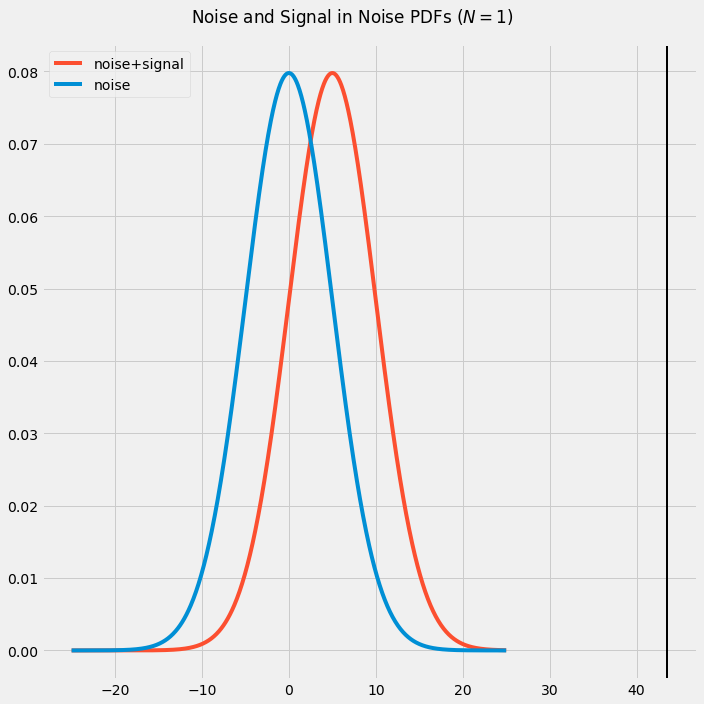

In [176]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'Noise and Signal in Noise PDFs ($N=1$)')

ax = axes
ax.plot(x, fs, color=COLORS[1])
ax.fill_between(x, np.zeros(x.shape), fs, where=x>gamma, color=COLORS[1], alpha=.4)

ax.plot(x, fn)
ax.fill_between(x, np.zeros(x.shape), fn, where=x>gamma, alpha=.4)
ax.legend(['noise+signal', 'noise'])
ax.axvline(x=gamma, ymin=0, ymax=1, lw=2, color='0')

plt.tight_layout()
plt.show()

#### **f)**
To imrove the signal-to-noise ratio of our detector, we increase the number of samples we look at before we take a decision about which PDF the samples are drawn from. We do this by first defining a new random variable, $z$, which we let represent the sum of the $N$ samples from $x$, now denoted $x_n$. Under this variable, the hypotheses become
$$
\begin{aligned}
H_0 &: z = \sum_{n=0}^{N-1} x_n = \sum_{n=0}^{N-1} n_n \\
H_1 &: z = \sum_{n=0}^{N-1} x_n = \sum_{n=0}^{N-1} (\theta + n_n) \\
\end{aligned}
$$
The statistics of $z$ are given by
$$
\begin{aligned}
\theta_z &= \mathbb{E}(z) \stackrel{H_1}{=} \mathbb{E} \bigg[ \sum_{n=0}^{N-1} (\theta + n_n) \bigg] = N \theta \\
\sigma_z^2 &= \mathbb{E}(z^2) \stackrel{H_0}{=} \mathbb{E} \bigg[ \bigg(  \sum_{n=0}^{N-1} n_n \bigg)^2 \bigg] = 
\mathbb{E} \bigg[ \bigg(\sum_{n=0}^{N-1} n_n \bigg) \bigg(\sum_{m=0}^{N-1} n_m \bigg) \bigg] = 
\mathbb{E} \bigg[ \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} n_n n_m \bigg] \\
&= \mathbb{E} \bigg[ \sum_{n=0}^{N-1} n_n^2 + \sum_{n \neq m} n_n n_m \bigg] = \mathbb{E} \big[ N\sigma^2 + 0 \big] = N\sigma^2
\end{aligned}
$$
This gives us the hypotheses
$$
\begin{aligned}
H_0 &: z \sim \mathcal{N}(0, N\sigma^2) \\
H_1 &: z \sim \mathcal{N}(N\theta, N\sigma^2) \\
\end{aligned}
$$
Given design paramaters $P_{FA} = 0.01 = \alpha, P_D > 0.9 = \beta$, we may use the survival functions to derive the threshold $\gamma$, as we did in **c)**;
$$
P_D = Q \bigg( \frac{\gamma - N\theta}{\sqrt{N}\sigma} \bigg) > \beta \stackrel{\text{antitonic}}{\Rightarrow} \frac{\gamma - N\theta}{\sqrt{N}\sigma} < Q^{-1}(\beta)
$$
and likewise for the false-alarm-rate
$$
P_{FA} = Q \bigg( \frac{\gamma}{\sqrt{N}\sigma} \bigg) = \alpha \Rightarrow \frac{\gamma}{\sqrt{N}\sigma} = Q^{-1}(\alpha)
$$
We solve the last equation w.r.t. $\gamma$;
$$
\gamma = \sqrt{N}\sigma Q^{-1}(\alpha)
$$
and insert it into the first (for $P_D$), which gives us the needed number of samples to make;
$$
N > \mathrm{ceil} \bigg[ \bigg(\frac{\sigma}{\theta}\bigg)^2 \bigg( Q^{-1}(\alpha) - Q^{-1}(\beta) \bigg)^2 \bigg] \approx \mathrm{ceil} [13.02] = 14
$$

In [173]:
# Calculating minimum number of samples
sigma, theta = 5, 5
P_D, P_FA = .9, .01
N = (sigma/theta*(norm.isf(P_FA) - norm.isf(P_D)))**2
N = np.ceil(N)
gamma = norm.isf(P_FA)*sqrt(N)*sigma
N, gamma

(14.0, 43.52198353555383)

In [175]:
# Controlling result
norm.sf(gamma, loc=0, scale=sigma*sqrt(N)), norm.sf(gamma, loc=N*theta, scale=sigma*sqrt(N))

(0.010000000000000016, 0.9215111164534591)

In [179]:
# Generating PDFs
N = 14
sigma, theta = sqrt(N)*5, N*5
x = np.linspace(-75,150,10000)
fn = norm.pdf(x, loc=0, scale=sigma)
fs = norm.pdf(x, loc=theta, scale=sigma)

# Threshold
alpha = .1
gamma = norm.isf(alpha)*sigma

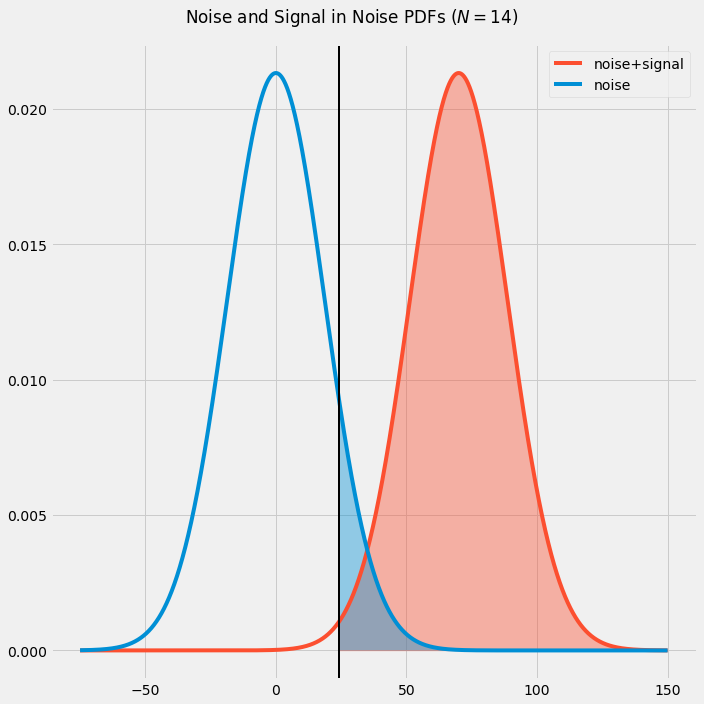

In [180]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle(r'Noise and Signal in Noise PDFs ($N=14$)')

ax = axes
ax.plot(x, fs, color=COLORS[1])
ax.fill_between(x, np.zeros(x.shape), fs, where=x>gamma, color=COLORS[1], alpha=.4)

ax.plot(x, fn)
ax.fill_between(x, np.zeros(x.shape), fn, where=x>gamma, alpha=.4)
ax.legend(['noise+signal', 'noise'])
ax.axvline(x=gamma, ymin=0, ymax=1, lw=2, color='0')

plt.tight_layout()
plt.show()